In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip uninstall tensorflow
!pip install tensorflow==1.13.2

Found existing installation: tensorflow 2.8.0
Uninstalling tensorflow-2.8.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.8.0.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
y
  Successfully uninstalled tensorflow-2.8.0
     |████████████████████████████████| 92.7 MB 1.2 MB/s 
     |████████████████████████████████| 50 kB 6.2 MB/s 
     |████████████████████████████████| 3.2 MB 59.9 MB/s 
     |████████████████████████████████| 367 kB 75.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8

In [3]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [4]:
import numpy as np
import pandas as pd 
import re
from tensorflow.keras.preprocessing.text import Tokenizer 
from nltk import download
download('stopwords')
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
import warnings
# from attention import AttentionLayer
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
print(tf.version.VERSION)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
1.13.2


In [5]:
checkpoint_path = "/content/drive/MyDrive/Colab Notebooks/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


In [6]:
reviews = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/data/Inshorts_Data.xlsx")
print(reviews.shape)
reviews.head()

(55104, 5)


,Headline,Short,Source,Time,Publish Date
0,4 ex-bank officials booked for cheating bank of ₹209 crore,"The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had avai...",The New Indian Express,09:25:00,2017-03-26
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme Court will go paperless in six to seven months in a bid to save funds and make the judiciary eco-friendly. He further said the apex court will collect ...,Outlook,22:18:00,2017-03-25
2,"At least 3 killed, 30 injured in blast in Sylhet, Bangladesh","At least three people were killed, including a policeman, while 30 others were wounded on Saturday evening in two explosions in Sylhet, Bangladesh. The explosions were targetted at people and poli...",Hindustan Times,23:39:00,2017-03-25
3,Why has Reliance been barred from trading in futures?,"Mukesh Ambani-led Reliance Industries (RIL) was barred from trading in futures market for a year over stake sale in Reliance Petroleum (RPL). In 2007, RIL sold 4.1% stake in RPL, but shares were f...",Livemint,23:08:00,2017-03-25
4,Was stopped from entering my own studio at Times Now: Arnab,"TV news anchor Arnab Goswami has said he was told he could not do the programme two days before leaving Times Now. &#34;18th November was my last day, I was not allowed to enter my own studio,&#34...",YouTube,23:24:00,2017-03-25


In [7]:
# Check for any nulls values
reviews.isnull().sum()

Headline        0
Short           0
Source          0
Time            0
Publish Date    0
dtype: int64

In [8]:
# let's inspect some reviews
for i in range(5):
    print("Review: ",i+1)
    print(reviews.Headline[i])
    print('-'*80)
    print(reviews.Short[i])
    print()

Review:  1
4 ex-bank officials booked for cheating bank of ₹209 crore
--------------------------------------------------------------------------------
The CBI on Saturday booked four former officials of Syndicate Bank and six others for cheating, forgery, criminal conspiracy and causing ₹209 crore loss to the state-run bank. The accused had availed home loans and credit from Syndicate Bank on the basis of forged and fabricated documents. These funds were fraudulently transferred to the companies owned by the accused persons.

Review:  2
Supreme Court to go paperless in 6 months: CJI
--------------------------------------------------------------------------------
Chief Justice JS Khehar has said the Supreme Court will go paperless in six to seven months in a bid to save funds and make the judiciary eco-friendly. He further said the apex court will collect all the records electronically from the lower courts and the high courts so that there is no need to file hard copies.

Review:  3
At

# Lets cleaned datasets

In [9]:
# Compile a regular expression pattern into a regular expression object, which can be used for matching using its match(), search() and other methods, described below.

CURRENCIES = {
    "$": "USD", "zł": "PLN", "£": "GBP", "¥": "JPY", "฿": "THB", "₡": "CRC", "₦": "NGN","₩": "KRW",
    "₪": "ILS", "₫": "VND", "€": "EUR", "₱": "PHP", "₲": "PYG", "₴": "UAH", "₹": "INR",}
CURRENCY_REGEX = re.compile(
    "({})+".format("|".join(re.escape(c) for c in CURRENCIES.keys())))

EMAIL_REGEX = re.compile(
    r"(?:^|(?<=[^\w@.)]))([\w+-](\.(?!\.))?)*?[\w+-]@(?:\w-?)*?\w+(\.([a-z]{2,})){1,3}(?:$|(?=\b))",
    flags=re.IGNORECASE | re.UNICODE,)

# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions =          {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have", "i've": "i have"}

In [10]:
def clean_text(text, remove_stopwords = True):
    
    text = text.lower()
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
        
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = EMAIL_REGEX.sub(' ',text)
    text = CURRENCY_REGEX.sub(' ',text)
    text = ' '.join([contractions[t] if t in contractions else t for t in text.split(" ")])    
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r"'s\b","", text)
    text = re.sub(r'&amp;', '', text) 
    
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text    

In [11]:
cleaned_headlines = []
cleaned_text = []

for headlines in reviews['Headline']:
    cleaned_headlines.append(clean_text(headlines, remove_stopwords=False))
print("Headlines are complete.")

for text in reviews['Short']:
    cleaned_text.append(clean_text(text))
print("Texts are complete.")

Headlines are complete.
Texts are complete.


In [12]:
# let's inspect some clean reviews
for i in range(4):
    print("Review: ",i+1)
    print(cleaned_headlines[i])
    print('-'*80)
    print(cleaned_text[i])
    print()

Review:  1
4 ex bank officials booked for cheating bank of  209 crore
--------------------------------------------------------------------------------
cbi saturday booked four former officials syndicate bank six others cheating forgery criminal conspiracy causing 209 crore loss state run bank accused availed home loans credit syndicate bank basis forged fabricated documents funds fraudulently transferred companies owned accused persons

Review:  2
supreme court to go paperless in 6 months  cji
--------------------------------------------------------------------------------
chief justice js khehar said supreme court go paperless six seven months bid save funds make judiciary eco friendly said apex court collect records electronically lower courts high courts need file hard copies

Review:  3
at least 3 killed  30 injured in blast in sylhet  bangladesh
--------------------------------------------------------------------------------
least three people killed including policeman 30 others 

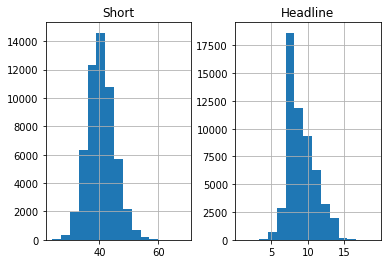

In [13]:
# distribution of sequences
import matplotlib.pyplot as plt

text_word_count = []
headlines_word_count = []

for i in cleaned_text:
    text_word_count.append(len(i.split()))
for i in cleaned_headlines:
    headlines_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Short': text_word_count, 'Headline': headlines_word_count})
length_df.hist(bins=15)
plt.show()

In [14]:
count = 0
for i in cleaned_text:
    if(len(i.split())<=55):
        count += 1
print(count/len(cleaned_text))

0.9982396922183507


In [15]:
max_headlines_len=15
max_text_len=55

cleaned_text = np.array(cleaned_text)
cleaned_headlines = np.array(cleaned_headlines)

short_text=[]
short_headlines=[]

for i in range(len(cleaned_text)):
    
    if(len(cleaned_headlines[i].split())<=max_headlines_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_headlines.append(cleaned_headlines[i])

df=pd.DataFrame({'Short':short_text,'Headline':short_headlines})
df['Headline'] = df['Headline'].apply(lambda x : 'sostok '+ x + ' eostok')

from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['Short']),np.array(df['Headline']),test_size=0.1,random_state=0,shuffle=True)

In [16]:
df.head()

,Short,Headline
0,cbi saturday booked four former officials syndicate bank six others cheating forgery criminal conspiracy causing 209 crore loss state run bank accused availed home loans credit syndicate bank basi...,sostok 4 ex bank officials booked for cheating bank of 209 crore eostok
1,chief justice js khehar said supreme court go paperless six seven months bid save funds make judiciary eco friendly said apex court collect records electronically lower courts high courts need fil...,sostok supreme court to go paperless in 6 months cji eostok
2,least three people killed including policeman 30 others wounded saturday evening two explosions sylhet bangladesh explosions targetted people police officials witnessing 30 hour long gunfight extr...,sostok at least 3 killed 30 injured in blast in sylhet bangladesh eostok
3,mukesh ambani led reliance industries ril barred trading futures market year stake sale reliance petroleum rpl 2007 ril sold 4 1 stake rpl shares first 39 short sold 39 futures market avoid fall r...,sostok why has reliance been barred from trading in futures eostok
4,tv news anchor arnab goswami said told could programme two days leaving times 34 18th november last day allowed enter studio 34 goswami added 34 build institution allowed enter studio feel sad 34 ...,sostok was stopped from entering my own studio at times now arnab eostok


In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

thresh=4
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

x_voc

% of rare words in vocabulary: 62.39495500602281
Total Coverage of rare words: 3.2316560822687883


26537

In [18]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh=6
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_headlines_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_headlines_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

y_tokenizer.word_counts['sostok'],len(y_tr)   

% of rare words in vocabulary: 71.31448536489714
Total Coverage of rare words: 6.675052150273229


(49457, 49457)

In [19]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [20]:
latent_dim = 200
embedding_dim=110

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
#model.load_weights('/content/drive/MyDrive/Colab Notebooks/cp_sw.ckpt')

model.summary() 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 55)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 55, 110)      2919070     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 55, 200), (N 248800      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer) 

In [21]:
model.load_weights(checkpoint_path)

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[cp_callback],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 49457 samples, validate on 5496 samples
Epoch 1/50
49408/49457 [============================>.] - ETA: 1s - loss: 1.9056
Epoch 00001: saving model to /content/drive/MyDrive/Colab Notebooks/cp.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.
49457/49457 [==============================] - 1676s 34ms/sample - loss: 1.9056 - val_loss: 2.7373
Epoch 2/50
49408/49457 [============================>.] - ETA: 1s - loss: 1.8920
Epoch 00002: saving model to /content/drive/MyDrive/Colab Notebooks/cp.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
49457/49457 [==============================] - 1658s 34ms/sample - loss: 1.8919 - val_loss: 2.7425
Epoch 3/50
49408/49457 [============================>.] - ETA: 1s - loss: 1.8813
Epoch 00003: saving model to /content/drive/MyDrive/Colab Notebooks/cp.ckpt

Consider using a TensorFlow optimizer 

In [ ]:
os.listdir(checkpoint_dir)

In [23]:
# !pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Save Keras Model or weights on google drive

# create on Colab directory
model.save('text_summary.h5')    
model_file = drive.CreateFile({'title' : 'text_summary.h5'})
model_file.SetContentFile('text_summary.h5')
model_file.Upload()

# download to google drive
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '1-NWSZ6TUsoBkV0La3-5IXqikaVtCzMBS'})

In [27]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_headlines_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [28]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: attempt restore law order maintain peace south kashmir indian army blending operation 39 calm 39 operation 39 ki 39 magical hug reports said operation army personnel interacted locals encouraged restore normalcy south kashmir virtual 39 jungle raj 39 reportedly run militants 
Original summary: army gives 39 ki 39 for peace in kashmir 
Predicted summary:  j amp k army 39 s 39 39 ki kashmir released


Review: 39 music cats 39 album comprising five cat friendly compositions topped itunes classical music chart cellist david allergic cats composed collection sounds aimed calm album released universal music reportedly becoming first major label release album human consumption n 
Original summary: 39 music for cats 39 tops music 
Predicted summary:  39 music 39 named most popular music album


Review: reacting anonymous blog alleging viral fever tvf founder arunabh kumar molestation former female employee actor naveen tuesday said 100 sure blog fake anonymous blogger claimed told mole

#### Rogue

In [29]:
!pip install sumeval
!python -m spacy download en

     |████████████████████████████████| 80 kB 7.2 MB/s 
     |████████████████████████████████| 90 kB 11.7 MB/s 
  Created wheel for sumeval: filename=sumeval-0.2.2-py3-none-any.whl size=54549 sha256=5f3df4e2cec61d839875a54ba8a6940a32fb131fbbd1b3db404b84dcdb20b4be
  Stored in directory: /root/.cache/pip/wheels/f4/3f/31/c521bdfba2be7518bd94ba3e8b982812822167cc0497fad192
Successfully built sumeval
     |████████████████████████████████| 12.0 MB 14.7 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [30]:
from sumeval.metrics.rouge import RougeCalculator

def eval_rouges(refrence_summary, model_summary):
    rouge = RougeCalculator(stopwords=True, lang="en")

    rouge_1 = rouge.rouge_n(
                summary=model_summary,
                references=refrence_summary,
                n=1)

    rouge_2 = rouge.rouge_n(
                summary=model_summary,
                references=[refrence_summary],
                n=2)
    
    rouge_l = rouge.rouge_l(
                summary=model_summary,
                references=[refrence_summary])
    
    # You need spaCy to calculate ROUGE-BE
    
    rouge_be = rouge.rouge_be(
                summary=model_summary,
                references=[refrence_summary])


    return rouge_1, rouge_2,rouge_l,rouge_be

In [31]:
from xml.etree.ElementTree import Element, SubElement, Comment
top = Element('ZakSum')

comment = Comment('Generated by Amr Zaki')
top.append(comment)

In [32]:
  from functools import reduce

In [ ]:
rouge_1_arr  = []
rouge_2_arr  = []
rouge_L_arr  = []
rouge_be_arr = []
i = 0
#for summ, longr in zip(summaries_val['short'], longreview_val['long']):#
for summ, longr in zip(y_tr, x_tr):#
  i = i  + 1
  print(i)
  print(" ")
  example = SubElement(top, 'example')
  rouge_1, rouge_2,rouge_L,rouge_be = eval_rouges(seq2summary(summ),decode_sequence(longr.reshape(1,max_text_len)))#
  
  eval_element = SubElement(example, 'eval')
  ROUGE_1_element  = SubElement(eval_element, 'ROUGE_1' , {'score':str(rouge_1)})
  ROUGE_2_element  = SubElement(eval_element, 'ROUGE_2' , {'score':str(rouge_2)})
  ROUGE_L_element  = SubElement(eval_element, 'ROUGE_l' , {'score':str(rouge_L)})
  ROUGE_be_element  = SubElement(eval_element,'ROUGE_be', {'score':str(rouge_be)})

  rouge_1_arr.append(rouge_1) 
  rouge_2_arr.append(rouge_2) 
  rouge_L_arr.append(rouge_L) 
  rouge_be_arr.append(rouge_be) 
  
  

print(rouge_1_arr)
rouge_1_avg = str(reduce(lambda x, y: x + y,  rouge_1_arr) / len(rouge_1_arr))
rouge_2_avg = str(reduce(lambda x, y: x + y,  rouge_2_arr) / len(rouge_2_arr))
rouge_3_avg = str(reduce(lambda x, y: x + y,  rouge_L_arr) / len(rouge_L_arr))
rouge_4_avg = str(reduce(lambda x, y: x + y, rouge_be_arr) / len(rouge_be_arr))

print(rouge_1_avg)
print(rouge_2_avg)
print(rouge_3_avg)
print(rouge_4_avg)